# DBA3713 Analytics for Risk Management

## Assignment 1 - Credit lending problem with logistic regression and its variants

### Due Date: Week 4 before class

## Assignment Overview

* The goal of this assignment is to take a step-by-step approach to solving the credit lending problem on a more realistic data set. 

* In this assignment, we will start from the ETL (Extract, Transform, Load) and data cleaning, followed by building logistic models, and finally, how to produce a credit decision rule. We will also explore variants of the logistic regression
* A dataset containing the full loan data has been uploaded on Luminus. 
* Please answer the questions and write the code/results in the blanks/empty cells. 
* 45 pts in total

In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Part 1. Data pre-processing 

<a id="Section_1.1"></a>
### 1.1 Load the data 
* Read data by pandas and name it as "loans". This step has been done for you.

In [2]:
# Read data by pandas and name it as "loans". This step has been done for you.

loans = pd.read_csv('lendingclub_full_data_set_no_id.csv')
loans.head(5)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,16000,60 months,12.74,361.93,C,C1,Aircraft Maintenance Technician,1 year,MORTGAGE,80000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25000,60 months,28.69,788.84,F,F1,Checker,5 years,MORTGAGE,75200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000,36 months,5.32,150.58,A,A1,Principal,8 years,RENT,95000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000,60 months,16.24,733.38,C,C5,Production Supervisor,10+ years,MORTGAGE,72900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7500,36 months,14.49,258.13,C,C4,Director Supplier Management,10+ years,MORTGAGE,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Show how many rows and columns such dataset has.

In [3]:
# Show how many rows and columns this dataset has
print(loans.shape)

print('-------------------')

# Cleaner answer
r, c = len(loans), len(loans.columns)
print('Rows: ' + str(r))
print('Cols: ' +str(c))

(24999, 132)
-------------------
Rows: 24999
Cols: 132


<a id="Section_1.2"></a>
### 1.2 Outcome variable 
The event of interest is whether a loan ends up in default or not. The variable "*loan_status*" best describes the information. We firstly take a close look at it.
* List all the unique values of "*loan_status*" and count how many are they in the data set

In [4]:
# list all the unique values of loan status and count the volume of them
unique_loan_status, count_loan_status = list(loans.loan_status.unique()), len(list(loans.loan_status.unique()))

print(unique_loan_status)

print('-------------------')
# Count of unique values 
print('Count of unique loan status values: ' + str(count_loan_status))

print('-------------------')
# Count of each unique value
print(loans.loan_status.value_counts())


['Current', 'Fully Paid', 'Charged Off', 'In Grace Period', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Default']
-------------------
Count of unique loan status values: 9
-------------------
Current                                                12063
Fully Paid                                              9733
Charged Off                                             2557
Late (31-120 days)                                       336
In Grace Period                                          174
Late (16-30 days)                                        101
Does not meet the credit policy. Status:Fully Paid        28
Does not meet the credit policy. Status:Charged Off        5
Default                                                    2
Name: loan_status, dtype: int64


* For simplicity, let us only include the loans with status is one of the following:
 * "Fully Paid"
 * "Charged Off"
 * "Late (31-120 days)"
 * "Default"
 

<div class="alert alert-warning">
<b>Suggestion: </b> Any deletion of rows could be followed by 'reset_index' to avoid such indexing issues later in the processing.

</div>

In [5]:
# Reset the "loans" dataset by only including the rows whose "loan_status" belongs to one of the following: 
# 'Fully Paid','Late (31-120 days)','Default' and 'Charged Off'
# Suggestion: any deletion of rows could be followed by reset_index to avoid such indexing issues later in the processing

desired_loan_status = ['Fully Paid','Late (31-120 days)','Default', 'Charged Off']

# Created copy of loans, filtered loans to prevent loss of original df.
filtered_loans = (loans.loc[loans['loan_status']
                        .apply(lambda x: x in desired_loan_status)]
                        .reset_index(drop = True))

# Check the unique values for loan_status
print(list(filtered_loans.loan_status.unique()))

['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']


* Convert loan status to binary values.

  *  Rule: A “good” loan = 1 (i.e., positive) and a “bad” loan = 0 (i.e., negative). A good loan means one that is fully paid and a bad one means otherwise.

In [6]:
# Convert loan status to binary values.
# Rule: A “good” loan = 1 (i.e., positive) and a “bad” loan = 0 (i.e., negative). 
# A good loan means one that is fully paid and a bad one means otherwise.
filtered_loans.loan_status = filtered_loans.loan_status.apply(lambda x: 1 if x == "Fully Paid" else 0)


* We have finisihed the pre-processing the loan status information. List again all the unique values of "loan_status" and count the volume of them



In [7]:
# List again all the unique values of "loan_status" and count the volume of them
list_filtered_loan_status = list(filtered_loans.loan_status.unique())
print(list_filtered_loan_status)

print('-------------------')
# Count of unique values 
print('Count of unique values: ' +str(len(list_filtered_loan_status)))

print('-------------------')
# Count of each type
print(filtered_loans.loan_status.value_counts())


[1, 0]
-------------------
Count of unique values: 2
-------------------
1    9733
0    2895
Name: loan_status, dtype: int64


<a id="Section_1.3"></a>
### 1.3 Feature Manipulation
Although as aforementioned we have 132 features, we select 26 out of them here for illustration. We may make further refinement as a further exercise of feature selection.  

In [8]:
# We consider the following pool of features
    
feature_pool = ['fico_range_high',
 'fico_range_low',
 'acc_now_delinq',
 'installment',
 'collections_12_mths_ex_med',
 'tax_liens',
 'verification_status',
 'revol_bal',
 'home_ownership',
 'total_acc',
 'annual_inc',
 'delinq_2yrs',
 'pub_rec_bankruptcies',
 'purpose',
 'loan_amnt',
 'open_acc',
 'revol_util',
 'sub_grade',
 'delinq_amnt',
 'chargeoff_within_12_mths',
 'inq_last_6mths',
 'pub_rec',
 'term',
 'dti','int_rate',
  'addr_state']


outcome = 'loan_status'

* Reset "loans" dataset by only including the features in the pool

In [9]:
# set the target variable
loans_outcome = filtered_loans[outcome]

# reset "loans" dataset by only including the features in the pool
filtered_loans = filtered_loans[feature_pool]

filtered_loans.head(5)

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,verification_status,revol_bal,home_ownership,total_acc,...,revol_util,sub_grade,delinq_amnt,chargeoff_within_12_mths,inq_last_6mths,pub_rec,term,dti,int_rate,addr_state
0,689,685,0.0,788.84,0.0,0.0,Verified,4697,MORTGAGE,23.0,...,54.0,F1,0.0,0.0,4.0,0.0,60 months,23.28,28.69,GA
1,719,715,0.0,733.38,0.0,0.0,Verified,7265,MORTGAGE,25.0,...,53.8,C5,0.0,0.0,2.0,0.0,60 months,13.94,16.24,IL
2,669,665,0.0,258.13,0.0,0.0,Not Verified,27092,MORTGAGE,27.0,...,80.4,C4,0.0,0.0,0.0,0.0,36 months,14.60,14.49,AZ
3,714,710,0.0,426.96,0.0,0.0,Verified,12986,RENT,17.0,...,46.4,B5,0.0,0.0,2.0,0.0,36 months,24.24,11.22,FL
4,739,735,0.0,544.29,0.0,0.0,Not Verified,13446,MORTGAGE,30.0,...,24.3,B5,0.0,0.0,3.0,0.0,36 months,22.22,13.67,FL


* Identify which columns are not numerical type

In [10]:
# List the types of all fields
filtered_loans.dtypes

# List non-numeric data
non_numeric_fields = filtered_loans.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

print(non_numeric_fields)

['verification_status', 'home_ownership', 'purpose', 'sub_grade', 'term', 'addr_state']


At this stage, you will find the following variables to be categorical: `home_ownership`, `term`, `sub_grade`, `addr_state`, `verification_status`, and `purpose`

* Pre-process the categorical variables by dealing with the outliers so that each value is not too rare in the data
  *  Proprocessing rules: 
     * For the variable `home_ownership`, rename the values of 'ANY and 'NONE' to 'OTHER'
     * For the variable `purpose`, rename the values of 'renewable_energy' and 'educational' to 'other'
     * For the variable `sub_grade`, rename the values of 'G1', 'G2', 'G3', 'G4', 'G5' to 'G'


In [11]:
# For all values of the 'home_ownership' variable that are 'ANY' or 'NONE', rename them to 'OTHER'
filtered_loans.home_ownership.loc[(filtered_loans['home_ownership'] == 'ANY') | (filtered_loans['home_ownership'] == 'NONE')] = 'OTHER'

# For all values of the 'purpose' variable that are 'renewable_energy' or 'educational', rename them to 'other'
filtered_loans.purpose.loc[(filtered_loans['purpose'] == 'renewable_energy') | (filtered_loans['purpose'] == 'educational')] = 'other'

# For all values of the 'sub_grade' variable that are 'G1', 'G2', 'G3', 'G4', or 'G5', rename them to 'G'
sub_grades_list = ['G1', 'G2', 'G3', 'G4', 'G5']
filtered_loans.sub_grade.loc[filtered_loans.sub_grade.isin(sub_grades_list)] = 'G'

* Transform categorical variables into numerical values

* Rules:
 * For every categorical variable with k alternatives, please replace it with k-1 dummy variables using one-hot encoding.
 * For example, '*home_ownership*' take value from four values: '**OWN**', '**RENT**', '**NONE**', '**MORTGAGE**', and '**OTHER**'. Create four dummies for '*home_ownership*' using one-hot encoding. Then drop the column "*home_ownership*", plus one of the four dummies to avoid the **multicollinearity** issue. Finally, integrate the three dummies to dataset. 
 * For other categorical variables, you may follow a similar process. 
 * You may find the method <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">get_dummies()</a> useful to automate the process.
 


In [12]:
# For every categorical variable with k alternatives, please replace it with k-1 dummy variables using one-hot encoding.
category_pool = ['home_ownership', 'term', 'sub_grade', 'verification_status','purpose','addr_state']

def split_and_encode(df, cat_list):

    for i in range(len(cat_list)):

        # K-1 dummy variables OHE to prevent dummy variable trap (MC)
        if len(df[cat_list[i]].unique()) > 1:
            df = pd.concat([df, pd.get_dummies(df[cat_list[i]], prefix = cat_list[i],  drop_first = True, dtype = 'int64')], axis = 'columns')
        
        # Dropping the un-encoded categorical variable column
        df.drop(cat_list[i], axis = 'columns', inplace = True)

    return df

loans_with_dummies = split_and_encode(filtered_loans, category_pool)
loans_with_dummies.head(5)

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,689,685,0.0,788.84,0.0,0.0,4697,23.0,75200.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,719,715,0.0,733.38,0.0,0.0,7265,25.0,72900.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,669,665,0.0,258.13,0.0,0.0,27092,27.0,180000.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,714,710,0.0,426.96,0.0,0.0,12986,17.0,61000.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,739,735,0.0,544.29,0.0,0.0,13446,30.0,55000.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Now that you have finished the transformation, 
 * Please make sure that all of them are of numerical type.
 * Also, count and print the number of features now after transformation

In [13]:
# Ensuring that all datatypes are numeric
loans_with_dummies.dtypes
non_numeric_fields_2 = loans_with_dummies.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

print('Number of non-numeric fields: ' + str(len(non_numeric_fields_2))) 

print('-------------------')

# Count the number of features now after transformation

print('Count of features after transformation: ' + str(len(loans_with_dummies.columns.tolist())))

# All fields should be of numerical types by this stage.

Number of non-numeric fields: 0
-------------------
Count of features after transformation: 116


* Check for missing values: count how many missing values there are in every column of the dataframe *loans*.

In [14]:
# Count how many missing values there are in every column of the dataframe loans.
print('Count of missing values in descending order')

print('-------------------')
print(loans_with_dummies.isna().sum().sort_values(ascending = False))

print('-------------------')

# Obtaining list of columns with missing values 
columns_with_missing_values = loans_with_dummies.columns[loans_with_dummies.isna().any()].tolist()
print('List of columns with missing values: ' + str(columns_with_missing_values))

Count of missing values in descending order
-------------------
revol_util                    8
pub_rec_bankruptcies          8
chargeoff_within_12_mths      1
collections_12_mths_ex_med    1
tax_liens                     1
                             ..
addr_state_KS                 0
addr_state_KY                 0
addr_state_LA                 0
addr_state_MA                 0
fico_range_high               0
Length: 116, dtype: int64
-------------------
List of columns with missing values: ['collections_12_mths_ex_med', 'tax_liens', 'pub_rec_bankruptcies', 'revol_util', 'chargeoff_within_12_mths', 'dti']


At this stage, you will find that the only variable with missing values is `tax_liens`, `revol_util`, `dti`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths` and `pub_rec_bankruptcies`

* Fill in the missing values: 
 * First, use its **median**  fill the missing values of those fields. You may find the the method <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">DataFrame.fillna()</a> useful to automate the process.
 * Then, check again whether there are any missing values

<div class="alert alert-warning">
<b>Note: </b> When you use fillna(), be careful with <B>replace</B> parameter because you need to modify the original variable but not a review.    
</div>

In [15]:
variables_to_complete = ['tax_liens','revol_util', 'dti', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies']

# Process missing values: use the median value of each field to fill in the missing values
def fill_with_median(df, var_list):
    for i in var_list:
        df[i] = df[i].fillna(df[i].median())
    return df

# Create a loans_final df and check replacement
loans_final = fill_with_median(loans_with_dummies, variables_to_complete)

In [16]:
# check again whether there are any missing values
print('Count of new missing values in descending order')

print('-------------------')
print(loans_final.isna().sum().sort_values(ascending = False))

print('-------------------')

# Obtaining list of columns with missing values 
columns_with_missing_values_final = loans_final.columns[loans_final.isna().any()].tolist()
print('Final list of columns with missing values: ' + str(columns_with_missing_values_final))

Count of new missing values in descending order
-------------------
addr_state_WY      0
sub_grade_D5       0
sub_grade_B3       0
sub_grade_B4       0
sub_grade_B5       0
                  ..
addr_state_KS      0
addr_state_KY      0
addr_state_LA      0
addr_state_MA      0
fico_range_high    0
Length: 116, dtype: int64
-------------------
Final list of columns with missing values: []


While we do not proceed further here, it is worth mentioning that there are further ways to "cleverly" select the features. For further read, you may find the discussion in <a href="https://scikit-learn.org/stable/modules/feature_selection.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Feature Selection</a> useful.

### 1.4 Data Splitting
* Randomly split the pre-processed loan data into training, validation and test set.
 * First, randomly shuffle the data using `np.random.RandomState(seed=42).permutation(n)`.  The random seed has been set to `seed = 42` to make sure the result is replicatable. 
   * The data shuffling has been done for you.
 * Second, assign each row to the train/validation/test set according to the following rule:
   * For rows 0-6999 (inclusive): assign them to the training set
   * For rows 7000-9999 (inclusive): assign them to the validation set
   * For the rest of the rows: assign them to the test set
  


In [17]:
# Join back the target column before randomising
loans = pd.concat([loans_final, loans_outcome], axis = 'columns')

# Randomly shuffle the data. This step has been done for you.
n = len(loans)
random_index = np.random.RandomState(seed=42).permutation(n)
loans = loans.iloc[random_index]
loans.reset_index(drop=True, inplace=True)

loans.head(5)

,fico_range_high,fico_range_low,acc_now_delinq,installment,collections_12_mths_ex_med,tax_liens,revol_bal,total_acc,annual_inc,delinq_2yrs,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,loan_status
0,719,715,0.0,289.14,0.0,0.0,10802,17.0,62500.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,694,690,0.0,305.31,0.0,0.0,2981,29.0,60000.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,679,675,0.0,864.80,0.0,0.0,104954,32.0,135000.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,689,685,0.0,566.52,0.0,0.0,5568,57.0,56000.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,704,700,0.0,240.59,0.0,0.0,15185,20.0,49000.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
# Split the pre-processed loan data into training, validation and test set
# Suggestion: any deletion of rows could be followed by reset_index to avoid such indexing issues later in the processing
train, val, test = loans.iloc[0:7000], loans.iloc[7000:10000], loans.iloc[10000:]

### 1.5 Data re-scaling
* Scale the training, validation, and test data sets. 
 * First, further split the training, validation, and test data sets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val` and `y_test`
 * Then, scale the feature information off all three datasets based on the mean and standard deviations of the training set 
   
This step is similar to what we did in the lecture. Note that scaling is important in improving the numerical stability.

<div class="alert alert-warning">
<b>Note: </b> In later parts of this assignment, we will also be using the unscaled version of the feature data. So please keep a copy of the unscaled features using the <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">copy()</a> method. (Or, you can keep the scaling coefficients so that you can transform the scaled data back to the unscaled ones.)
</div>

In [19]:
# Remove target column to create feature only dataset: 'X_train', 'X_val', and 'X_test', respectively 
X_train = train.drop('loan_status', 1)
X_val = val.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

# Keep a copy of the unscaled features using the ".copy()" method, and name them 'X_train_unscale', 'X_val_unscale', and 'X_test_unscale', respectively
X_train_unscale, X_val_unscale, X_test_unscale = X_train.copy(), X_val.copy(), X_test.copy()

# Scale 'X_train', 'X_val', and 'X_test' data using the mean and standard deviation of the training set. 
X_test=(X_test-X_train.mean())/X_train.std()
X_val=(X_val-X_train.mean())/X_train.std()
X_train=(X_train-X_train.mean())/X_train.std()


# Store target column as y-variables in the following datasets: 'y_train', 'y_val', and 'y_test'
y_train = train['loan_status']
y_val = val['loan_status']
y_test = test['loan_status']


### 1.6  Summary
* Please print the following:
  * The first five instances for training, validation, and test data sets, respectively
  * The percentages of all outcome levels for each data set
  * The shapes of the split datasets
  * Feature names

In [20]:
# Print the first five instances for training, validation, and test data sets, respectively, as well as the percentages of all outcome levels
print('Training data: ')
print(X_train.head(5))

# Frequency of different classes in training set
freq = y_train.value_counts()           
print('\nPercentage of all outcomes: ' )                     
print(freq/sum(freq)*100) 

Training data: 
   fico_range_high  fico_range_low  acc_now_delinq  installment  \
0         0.632298        0.632335       -0.069226    -0.571987   
1        -0.166243       -0.166241       -0.069226    -0.507801   
2        -0.645367       -0.645386       -0.069226     1.713049   
3        -0.325951       -0.325956       -0.069226     0.529051   
4         0.153174        0.153190       -0.069226    -0.764702   

   collections_12_mths_ex_med  tax_liens  revol_bal  total_acc  annual_inc  \
0                   -0.120641  -0.143146  -0.266121  -0.698690   -0.236840   
1                   -0.120641  -0.143146  -0.669710   0.310075   -0.283198   
2                   -0.120641  -0.143146   4.592428   0.562267    1.107559   
3                   -0.120641  -0.143146  -0.536212   2.663861   -0.357372   
4                   -0.120641  -0.143146  -0.039944  -0.446499   -0.487176   

   delinq_2yrs  ...  addr_state_SD  addr_state_TN  addr_state_TX  \
0    -0.361361  ...      -0.041437      -0.1

In [21]:
# Print the first five instances for training, validation, and test data sets, respectively, as well as the percentages of all outcome levels
print('-------------------')
print('Validation data: ')
print(X_val.head(5))

# Frequency of different classes in validation set
freq = y_val.value_counts()           
print('\nPercentage of all outcomes: ' )                     
print(freq/sum(freq)*100)

-------------------
Validation data: 
      fico_range_high  fico_range_low  acc_now_delinq  installment  \
7000        -0.166243       -0.166241       -0.069226     1.356238   
7001        -1.124492       -1.124532       -0.069226    -1.318516   
7002         0.792007        0.792051       -0.069226    -0.285236   
7003        -0.645367       -0.645386       -0.069226     1.043130   
7004         0.472590        0.472620       -0.069226     2.022386   

      collections_12_mths_ex_med  tax_liens  revol_bal  total_acc  annual_inc  \
7000                   -0.120641  -0.143146   0.211003   0.057884   -0.209025   
7001                   -0.120641  -0.143146  -0.490182  -1.034945   -0.969305   
7002                   -0.120641  -0.143146  -0.244241  -1.203073   -0.005047   
7003                   -0.120641   2.978411  -0.250588  -0.950881    0.087670   
7004                   -0.120641  -0.143146   1.187130  -0.278371    0.736690   

      delinq_2yrs  ...  addr_state_SD  addr_state_TN  

In [22]:
# Print the first five instances for training, validation, and test data sets, respectively, as well as the percentages of all outcome levels
print('-------------------')
print('Testing data: ')
print(X_test.head(5))

# Frequency of different classes in test set
freq = y_test.value_counts()           
print('\nPercentage of all outcomes: ' )                     
print(freq/sum(freq)*100)

-------------------
Testing data: 
       fico_range_high  fico_range_low  acc_now_delinq  installment  \
10000         3.507046        3.507209       -0.069226     1.029674   
10001         0.472590        0.472620       -0.069226     1.823439   
10002        -0.325951       -0.325956       -0.069226     0.877844   
10003        -0.166243       -0.166241       -0.069226    -1.451769   
10004         1.750256        1.750342       -0.069226     1.252914   

       collections_12_mths_ex_med  tax_liens  revol_bal  total_acc  \
10000                   -0.120641  -0.143146  -0.317156  -0.782754   
10001                   -0.120641  -0.143146   1.061682  -0.278371   
10002                   -0.120641  -0.143146   0.103668   0.226011   
10003                   -0.120641  -0.143146  -0.323813  -0.026180   
10004                   -0.120641  -0.143146   5.575366   0.057884   

       annual_inc  delinq_2yrs  ...  addr_state_SD  addr_state_TN  \
10000   -0.375915    -0.361361  ...      -0.0414

In [23]:
# Print the shapes of the split datasets
print('-------------------')
print('Shapes of the split datasets: ')
print(X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape)


# Print the feature names
print('-------------------')
print('Feature names: ')
print(X_train.columns.values)

-------------------
Shapes of the split datasets: 
(7000, 116) (7000,) (3000, 116) (3000,) (2628, 116) (2628,)
-------------------
Feature names: 
['fico_range_high' 'fico_range_low' 'acc_now_delinq' 'installment'
 'collections_12_mths_ex_med' 'tax_liens' 'revol_bal' 'total_acc'
 'annual_inc' 'delinq_2yrs' 'pub_rec_bankruptcies' 'loan_amnt' 'open_acc'
 'revol_util' 'delinq_amnt' 'chargeoff_within_12_mths' 'inq_last_6mths'
 'pub_rec' 'dti' 'int_rate' 'home_ownership_OTHER' 'home_ownership_OWN'
 'home_ownership_RENT' 'term_ 60 months' 'sub_grade_A2' 'sub_grade_A3'
 'sub_grade_A4' 'sub_grade_A5' 'sub_grade_B1' 'sub_grade_B2'
 'sub_grade_B3' 'sub_grade_B4' 'sub_grade_B5' 'sub_grade_C1'
 'sub_grade_C2' 'sub_grade_C3' 'sub_grade_C4' 'sub_grade_C5'
 'sub_grade_D1' 'sub_grade_D2' 'sub_grade_D3' 'sub_grade_D4'
 'sub_grade_D5' 'sub_grade_E1' 'sub_grade_E2' 'sub_grade_E3'
 'sub_grade_E4' 'sub_grade_E5' 'sub_grade_F1' 'sub_grade_F2'
 'sub_grade_F3' 'sub_grade_F4' 'sub_grade_F5' 'sub_grade_G'
 'ver

# Part 2. Predicting with (basic) Logistic Regression 

Let us divide this step into three stage: model training, decision criterion selection, and performance evaluation. The test data should be **only** used in the last stage. 

### 2.1 Model training
* Fit a LogisticRegression model using the training data. 
 * Please use the scikit-learn package <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Logistic Regression</a>
 * The training parameters we use are: 
   * `penalty="none"` (It means there is no regularization) 
   *  `solver="newton-cg"` (It means we use the newton-cg method to solve the MLE problem. This is a slightly more advanced algorithm than what we used in class.)
 * Print the trained coefficients

In [24]:
#Fit a LogisticRegression model using the training data
lgstc_reg =  LogisticRegression(penalty="none",solver="newton-cg")  
lgstc_reg.fit(X_train, y_train)


# Print the estimated coefficients / trained coefficients
print('The trained coefficients for the logistic regression:')
print(lgstc_reg.intercept_, lgstc_reg.coef_)

The trained coefficients for the logistic regression:
[1.45693014] [[ 1.70531127e+02 -1.70308179e+02 -3.88818871e-02 -6.90353127e-01
  -5.66144268e-03 -7.45413466e-02  7.44770368e-02  2.18458686e-01
   5.98950842e-02 -8.51754237e-02 -8.94467984e-02  6.30721738e-01
  -2.10906588e-01  2.03696164e-02  5.01431994e-02  1.26728528e-02
  -5.67876004e-02  1.32450501e-01 -2.54391067e-01  6.49209580e-01
   3.26794353e-01 -5.27839958e-02 -1.34459282e-01 -4.23680427e-01
  -8.92774418e-02 -9.52122831e-02 -1.92897457e-02 -2.00712335e-01
  -2.23884718e-01 -2.30990515e-01 -2.86843955e-01 -4.03245151e-01
  -4.12499891e-01 -4.44394075e-01 -4.44928418e-01 -5.28811637e-01
  -5.78164050e-01 -5.09348990e-01 -4.74192594e-01 -5.17200412e-01
  -4.62798283e-01 -5.43817707e-01 -4.41614251e-01 -4.75730443e-01
  -4.32239393e-01 -4.54675540e-01 -3.66198134e-01 -4.37507027e-01
  -3.13841305e-01 -3.02193432e-01 -2.89162838e-01 -2.84351642e-01
  -2.38684632e-01 -3.48615456e-01 -3.00155625e-02 -5.12979890e-02
  -1.8120

### 2.2 Decision criterion

In this assignment, we will choose the decision criterion based on the validation data according to the expected payoff objective. For simplicity, let us assume that the payoff from a good loan is loan amount times multiplied by the interest rate, and the loss from a bad loan is the loan amount itself. (That is, there is no recovery from a bad loan.) 

* Please report the following quantities:
  * The average interest rate (in percentage number) in the **UNSCALED** training, validation, and test datasets
  * The average loan amount (in USD) in the **UNSCALED** training, validation, and test datasets

In [25]:
# Print the average interest rate and loan amount in the unscaled training, validation, and test datasets

# Training set
avg_int_train, avg_loan_train = X_train_unscale.int_rate.mean(), X_train_unscale.loan_amnt.mean()
print('Avg interest rate (Train): '+ str(avg_int_train))
print('Avg loan amount (Train): '+ str(avg_loan_train))
print('-------------------')

# Validation set
avg_int_val, avg_loan_val = X_val_unscale.int_rate.mean(), X_val_unscale.loan_amnt.mean()
print('Avg interest rate (Val): '+ str(avg_int_val))
print('Avg loan amount (Val): '+ str(avg_loan_val))
print('-------------------')

# # Test set
avg_int_test, avg_loan_test = X_test_unscale.int_rate.mean(), X_test_unscale.loan_amnt.mean()
print('Avg interest rate (Test): '+ str(avg_int_test))
print('Avg loan amount (Test): '+ str(avg_loan_test))

Avg interest rate (Train): 13.52306428571454
Avg loan amount (Train): 14233.028571428571
-------------------
Avg interest rate (Val): 13.619126666666727
Avg loan amount (Val): 14311.575
-------------------
Avg interest rate (Test): 13.498044140030544
Avg loan amount (Test): 14268.635844748858


*  Write a Python function `get_EP` that calculates, for every given threshold, the expected payoff from a randomly drawn borrower based on the average interest rates/loan amounts 
    * The Python function should allow the user to specify whether to perform the calculation on validation or test data
    * Please set the profit parameter "P" to be the average interest times times the average loan amount
    * Please set the loss parameter "L" to be the average loan amount
    * You can write additional functions if needed, and use/modify the codes provided in the lecture


In [26]:
# You can use the functions below (if needed)

def get_data(evaluate_on):
    ###########
    # Get the validation/training data, depending on the data mode
    # Input: evaluate_on is either 'test' or 'validate', meaning whether the evaluation is performed on the validation or test data
    # Output: the appropriate feature and outcome data as a tuple
    ###########
    
    if evaluate_on == 'test':
        X,y,X_unscale = X_test, y_test, X_test_unscale
    elif evaluate_on == 'validate':
        X,y,X_unscale = X_val, y_val, X_val_unscale
    else:
        print('Error: evaluate_on must be either "test" or "validate"')
        X, y, X_unscale  = (None, None, None)
        
    return X,y, X_unscale
    
    

def get_cm(z, reg_model, evaluate_on ):
    
    ###########
    # Get the confusion matrix of given the threshold, classifier and the dataset
    # Input: z is the threshold
    #        reg_model is the sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data
    # Output: the confusion matrix
    ###########
    

    # Get the appropriate feature and outcome data    
    X,y, _ = get_data(evaluate_on)
    
    
    # If prob for data set > threshold predict 1
    preds = np.where(reg_model.predict_proba(X)[:,1] > z, 1, 0)                                      
    
    ''' # Print the acceptance rate. Uncomment if needed.
    print('Number of loans accepted: ', np.sum(preds) )
    print('Number of loans rejected: ', np.sum(1-preds) )'''
    
    # create confusion matrix 
    cm = confusion_matrix(y, preds,labels=[1, 0], sample_weight=None) # confusion matrix 
    
    return cm



def get_ratios(cm):
    ###########
    # Get the relavant ratios given a confusion matrix
    # Input: cm is a 2*2 confusion matrix
    # Output: Accuracy, TPR, FNR, TNR, and FPR
    ###########
    
    
    TP = cm[0][0] # True Positives                                                                                          
    FN = cm[0][1] # False Positives                                                                                          
    FP = cm[1][0] # True Negatives                                                                                          
    TN = cm[1][1] # False Negatives                                                                                          
        
    TPR = TP/(TP+FN) # True Positive Rate (sensitivity/recall)                                                                                       
    FNR = FN/(TP+FN) # False Negative Rate (miss rate)                                                                                      
    TNR = TN/(TN+FP) # True Negative Rate (specificity)                                                                                      
    FPR = FP/(TN+FP) # False Positive Rate (fall-out) 
    
    Accuracy = (TP+TN)/(TP+FN+FP+TN)
    
    return Accuracy, TPR, FNR, TNR, FPR



In [27]:
def get_EP(z, reg_model, evaluate_on, avg_int, avg_loan_amt):
    
    ###########
    # Evaluate the (realized) expected payoff given the threshold, classifier, and based on the validation/test data set
    # Input: z is the threshold
    #        reg_model is a sklearn classifier
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is generated from the...
    #        validation data or test data
    # Output: The (realized) expected payff from an average borrower
    # Note: The gain and loss parameters P and L should be estimated from the validation/test data
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y, X_unscale = get_data(evaluate_on) # Toggles between test and val sets

    # Please fill in your codes here. 

    # get confusion matrix 
    cm = get_cm(z, reg_model, evaluate_on)
    
    # get the relavant ratios
    Accuracy, TPR, FNR, TNR, FPR = get_ratios(cm)
    
    # Get the fraction of good/bad loans
    frac_p = np.sum(y)/len(y) #the fraction of positive outcomes (i.e., good loans) in the validation dataset
    frac_n = np.sum(1-y)/len(y) #total number of negative outcomes (i.e., bad loans) in the validation dataset
    
    # The expected value is P * "Good loan"% * TPR - L * "Bad Loan"% * FPR
    P, L = avg_int*avg_loan_amt/100, avg_loan_amt
    EP = P * frac_p * TPR - L * frac_n * FPR 

    return EP

*  Complete the following two tasks: 
    * Plot the expected payoff curve of the logistic regression model.
    * Please also find the optimal threshold and store it in the variable `z_optimal`
    * Both tasks should be based on the **validation** data

In [28]:
# You can directly use the functions below (if needed)

# Let the threshold Z range from 0.5 to 1. 
zrange_default = np.arange(0.5,1,0.001) # a grid search for the threshold 


def EP_curve(reg_model, evaluate_on, avg_int, avg_loan_amt, zrange):
    
    ###########    
    # Evaluate and plot the (realized) expected payoff curve. Also, we obtain the threshold based on the curve.
    # Input: reg_model is the classifier of interest
    #        evaluate_on is either 'test' or 'validate', 
    #        meaning whether the evaluation is based on validation or test data
    #        zrange is the range that the treshold Z takes value in
    # Output: The optimal threshold
    ###########

    # We calculate the expected payoff as a function of Z
    EP_lr = np.array([get_EP(z, reg_model, evaluate_on, avg_int, avg_loan_amt)  for z in zrange]) #The expected payoff curve for the logistic regression
    EP_rg = EP_lr[0] + zrange * (EP_lr[-1] - EP_lr[0]) #The expected payoff curve for the random guess predictor

    plt.plot( zrange, EP_rg,linestyle='--',color = 'black', label='Random Predction')
    plt.plot( zrange , EP_lr,label='Logistic Regression')

    plt.xlabel('Z')
    plt.ylabel('Expected payoff')
    plt.legend()
    plt.show()

    # Analysis of the optimal threshold

    z_optimal = zrange [np.argmax(EP_lr)]

    print('-------------------')
    print('The optimal Z is: ', z_optimal)
    print('Evaluated on: the %s data set' %evaluate_on)
    print('-------------------')

    print('   The maximual expected payoff is: $', np.max(EP_lr).round(2) )
    print('-------------------')

    print('   The confusion matrix under the optimal Z is: ')
    print(get_cm(z_optimal, reg_model, evaluate_on))
    print('-------------------')

    Accuracy, TPR, FNR, TNR, FPR = get_ratios (get_cm(z_optimal, reg_model, evaluate_on))
    print('   The relavant ratios under the optimal Z are: ')
    print('   Accuracy rate:', Accuracy, ' TPR:', TPR, ' FPR:',  FPR)
    print('-------------------')

    return z_optimal 

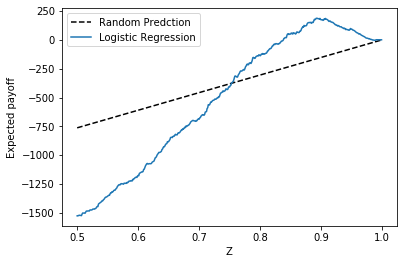

-------------------
The optimal Z is:  0.8920000000000003
Evaluated on: the validate data set
-------------------
   The maximual expected payoff is: $ 187.47
-------------------
   The confusion matrix under the optimal Z is: 
[[ 641 1646]
 [  48  665]]
-------------------
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.43533333333333335  TPR: 0.28027984258854394  FPR: 0.06732117812061711
-------------------


0.8920000000000003

In [29]:
# Plot the expected payoff curve of the logistic regression model and print 'z_optimal', 
# both based on the validation data
z_optimal = EP_curve(lgstc_reg, 'validate', avg_int_val, avg_loan_val, zrange_default)
z_optimal

### 2.3 Performance evaluation

#### 2.3.1  The performance of the logistic regression as a classifier
*  (Possibly building on the lecture codes) Report the MLE loss function values on training, validation, and test datasets

In [30]:
# You can directly use the functions below (if needed)

def loss_evaluation (reg_model):
    
    # y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
    # validation set and test set using the fitted logistic regression model

    y_train_pred=reg_model.predict_proba(X_train)
    y_val_pred=reg_model.predict_proba(X_val)
    y_test_pred=reg_model.predict_proba(X_test)

    # Calculate maximum likelihood for training set, validation set, and test set

    mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0]))
    mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
    mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

    # Calculate loss functions from maximum likelihoods

    loss_function_training = np.negative(np.sum(mle_vector_train)/len(y_train))
    loss_function_val = np.negative(np.sum(mle_vector_val)/len(y_val))
    loss_function_test = np.negative(np.sum(mle_vector_test)/len(y_test))
    
    return loss_function_training, loss_function_val, loss_function_test

In [31]:
# Print the MLE loss function values on training, validation, and test datasets
loss_function_training, loss_function_val, loss_function_test = loss_evaluation(lgstc_reg)
print('MLE loss function for training set =', loss_function_training)
print('MLE loss function for validation set =', loss_function_val)
print('MLE loss function for test set =', loss_function_test)


MLE loss function for training set = 0.4726109237831029
MLE loss function for validation set = 0.5034663665683796
MLE loss function for test set = 0.49720213438083677


* (Possibly building on the lecture codes) Report the AUC score for the logistic regression classifier  (based on the **test** data).

In [32]:
# You can directly use the functions below (if needed)
def get_AUC(reg_model, evaluate_on):
    
    ###########
    # Plot the ROC curve of a given classifier and the data to evaluate on. Also, calculate the AUC measure.
    # Input: reg_model is a sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data. By default, the ROC curve is evaluated on the test data.
    # Output: The AUC measure. Also, plot the curve.
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y, _ = get_data (evaluate_on)
    
    # Get the predicted probablities from the current model and from random predictions
    model_prob = reg_model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    
    return model_auc

In [33]:
# Print the AUC measure of the logistic regression on the test data
print('AUC measure of the logistic regression on test data: ' + str(get_AUC(lgstc_reg, 'test').round(3)))

AUC measure of the logistic regression on test data: 0.686


#### 2.3.1  The performance of the loan acceptance rule

Let us consider the loan acceptance rule determined by the logistic regression classifier with the threshold `z_optimal`. The evaluation should be based on the **test** data

* Evaluate and print the confusion matrix 

In [34]:
# Print the confusion matrix (based on the test data)
print('Confusion matrix at z_optimal using test data:  ')
print(get_cm(z_optimal, lgstc_reg, 'test'))

print('-------------------')

# Evaluation of confusion matrix
print('Evaluation of confusion matrix on test data')

eval_metrics = pd.DataFrame(["Accuracy", "True Positive Rate", "False Negative Rate", "True Negative Rate", "False Positive Rate"])
ratios = pd.DataFrame(get_ratios(get_cm(z_optimal, lgstc_reg, 'test')))
results = pd.concat([eval_metrics, ratios], axis= 'columns')

print(results)

Confusion matrix at z_optimal using test data:  
[[ 589 1445]
 [  56  538]]
-------------------
Evaluation of confusion matrix on test data
                     0         0
0             Accuracy  0.428843
1   True Positive Rate  0.289577
2  False Negative Rate  0.710423
3   True Negative Rate  0.905724
4  False Positive Rate  0.094276


* Evaluate the expected payoff of the loan based on the average interest rates and loan amounts

In [35]:
# Evaluate the expected payoff of the loan based on the average interest rates and loan amounts in the test data
print('EP at z_optimal using test data:  $' + str(get_EP(z_optimal, lgstc_reg, 'test', avg_int_test, avg_loan_test).round(2)))

EP at z_optimal using test data:  $127.61


# Part 3. Improving the Prediction using Regularization

Let us use L1 regularization to improve the prediction model and ultimately, the loan acceptance decision. 

* Let the regularization parameter Lambda range from 5 to 145. For each lambda, fit a logistic regression with L1 regularization. Plot three curves to answer the following three questions:
  * (1) How does the number of non-zero coefficients change with respect to lambda?
  * (2) How does the MLE loss function value change with respect to lambda for the training, validation, and test data, respectively? (You can plot three curves on the same graph)
  * (3) How does the AUC score change with respect to lambda for the validation and test, respectively? (You can plot two curves on the same graph)
  

  
* The training parameters we use are: 
   * `penalty="l1"` (It means we use L1 regularization) 
   *  `solver="liblinear"` (It means we use the liblinear method as the solver, which is slightly more specialized to the training problem with L1 regularization)


In [36]:
# Let the regularization parameter Lambda range from 5 to 145. (We use LAMBDA to store its range.) 
# For each lambda, fit a logistic regression with L1 regularization. 
# Plot three curves to answer the following three questions:
# (1) How does the number of non-zero coefficients change with respect to lambda?
# (2) How does the MLE loss function value change with respect to lambda for the training, validation, and test data, respectively? (You can plot three curves on the same graph)
# (3) How does the AUC score change with respect to lambda for the validation and test, respectively? (You can plot two curves on the same graph)

# The range of lambda values
LAMBDA = np.arange(5,155, 10)

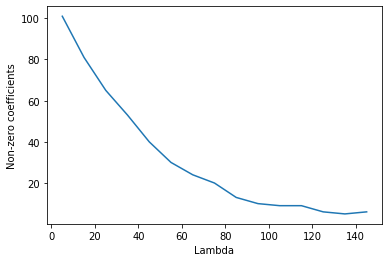

In [37]:
# Plot the number of non-zero coefficients for the l1-regularized logistic regression as lambda changes
def plot_non_zero_coeff_l1(LAMBDA):
    count_non_zero_coefs = []
    # Iterate over the lambda values
    for lamb in LAMBDA:
        
        #Create an instance of logisticregression named lgstc_reg_l1
        lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)
        
        # Fit logististic regression to training set
        lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

        # Count all non-zero coefficients
        count = np.sum(lgstc_reg_l1.coef_ != 0)
        count_non_zero_coefs.append(count)

    ax = plt.gca()
    plt.xlabel("Lambda")
    plt.ylabel("Non-zero coefficients")
    ax.plot(LAMBDA, count_non_zero_coefs)

plot_non_zero_coeff_l1(LAMBDA)

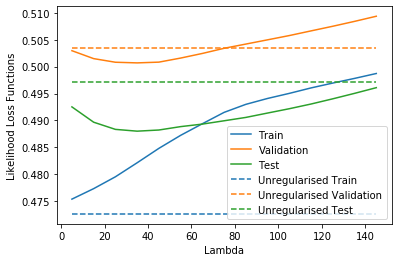

In [38]:
# Plot the likelihood loss function values (on training, validation, and test data sets) for the l1-regularized logistic regression as lambda changes (3-in-1)
def plot_loss_func_l1(LAMBDA):

    loss_func_lst, loss_func_benchmark = [], []

    for lamb in LAMBDA:
        #Create an instance of logisticregression named lgstc_reg_l1
        lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

        # Fit logististic regression to training set
        lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

        # Store three values in list item for every lambda
        loss_func_lst.append(loss_evaluation(lgstc_reg_l1))

        # To visualise the loss before and after regularisation
        loss_func_benchmark.append(loss_evaluation(lgstc_reg))

    # Slice into 3
    train_losses    = [i[0] for i in loss_func_lst]
    val_losses      = [i[1] for i in loss_func_lst]
    test_losses     = [i[2] for i in loss_func_lst]

    # Plot 3 in 1
    
    plt.plot(LAMBDA, train_losses, label = "Train", color = 'tab:blue')
    plt.plot(LAMBDA, val_losses, label = "Validation", color = 'tab:orange')
    plt.plot(LAMBDA, test_losses, label = "Test", color = 'tab:green')
    plt.xlabel("Lambda")
    plt.ylabel("Likelihood Loss Functions")


    # Not in qn but to show original likelihood loss
    train_bench     = [i[0] for i in loss_func_benchmark]
    val_bench       = [i[1] for i in loss_func_benchmark]
    test_bench      = [i[2] for i in loss_func_benchmark]

    # Plot benchmarks    
    plt.plot(LAMBDA, train_bench , label = "Unregularised Train", linestyle = 'dashed', color = "tab:blue")
    plt.plot(LAMBDA, val_bench , label = "Unregularised Validation", linestyle = 'dashed', color = "tab:orange")
    plt.plot(LAMBDA, test_bench , label = "Unregularised Test", linestyle = 'dashed', color = "tab:green")


    plt.legend()

plot_loss_func_l1(LAMBDA)

Maximum point for val (45, 0.7014186532698078)
Maximum point for test (75, 0.698497594761115)


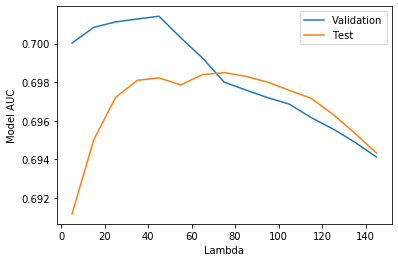

In [39]:
# Plot the AUC measures for the l1-regularized logistic regression as lambda changes
def plot_auc_l1(LAMBDA):
    auc_lst_val, auc_lst_test = [], []

    for lamb in LAMBDA:
        #Create an instance of logisticregression named lgstc_reg_l1
        lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

        # Fit logististic regression to training set
        lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

        auc_lst_val.append(get_AUC(lgstc_reg_l1,'validate'))
        auc_lst_test.append(get_AUC(lgstc_reg_l1,'test'))


    # find max points 
    def find_max_point(x,y):
        max_x, max_y = x[np.argmax(y)] , max(y)
        return (max_x, max_y)

    # max point for validation
    print("Maximum point for val " + str(find_max_point(LAMBDA, auc_lst_val)))

    # max point for test
    print("Maximum point for test " + str(find_max_point(LAMBDA, auc_lst_test)))

    # Plot 2 in 1
    plt.plot(LAMBDA, auc_lst_val, label = "Validation")
    plt.plot(LAMBDA, auc_lst_test, label = "Test")
    plt.xlabel("Lambda")
    plt.ylabel("Model AUC")
    plt.legend()


plot_auc_l1(LAMBDA)

* Suppose somebody has determined that the optimal regularization parameter is `lambda_optimal` = 40. What is the optimal threshold Z that obtains the highest expected payoff on the **validation** set? 

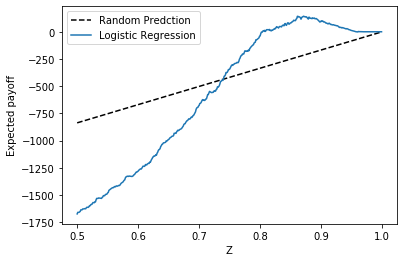

-------------------
The optimal Z is:  0.8710000000000003
Evaluated on: the validate data set
-------------------
   The maximual expected payoff is: $ 142.68
-------------------
   The confusion matrix under the optimal Z is: 
[[ 528 1759]
 [  42  671]]
-------------------
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.39966666666666667  TPR: 0.23087013554875382  FPR: 0.05890603085553997
-------------------
0.8710000000000003


In [40]:
# Suppose somebody has determined that the optimal regularization parameter is lambda_optimal = 40. 
lambda_optimal = 40

# What is the optimal threshold Z that obtains the highest expected payoff on the validation set? 
def find_optimal_z_val(lamb, avg_int, avg_loan_amt, zrange):
    # Create optimal instance of logisticregression named lgstc_reg_l1
    lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

    # Fit logististic regression to training set
    lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

    # Return z_optimal
    return EP_curve(lgstc_reg_l1, 'validate', avg_int, avg_loan_amt, zrange)

# Save it in the variable 'z_optimal_l1' and print its value

z_optimal_l1 = find_optimal_z_val(lambda_optimal, avg_int_val,avg_loan_val, zrange_default)
print(z_optimal_l1)

* Evaluate the prediction model on the **test** data set using the following metrics:
   * AUC score of the classifier
   * Confusion matrix (given the previously chosen threshold)
   * Expected payoff (given the previously chosen threshold)

In [41]:
# Evaluate the prediction model on the test data using the following metrics:
# (1) AUC score of the classifier
# (2) Confusion matrix (given the previously chosen threshold 'z_optimal_l1')
# (3) Expected payoff (given the previously chosen threshold 'z_optimal_l1')

In [42]:
# Print the AUC score of the regualized logistics classifier on the test data

def find_l1_model_auc(lamb):
    #Create an instance of logisticregression named lgstc_reg_l1
    lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

    # Fit logististic regression to training set
    lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

    return get_AUC(lgstc_reg_l1, 'test')

print('The AUC score of the regularized classifier is: ' + str(find_l1_model_auc(lambda_optimal).round(3))) # Need to find out which lambda to use for regression, do we continue using the "ideal" lambda?

The AUC score of the regularized classifier is: 0.698


In [43]:
# Print the confusion matrix of the regualized logistics classifier on the test data (given the previously chosen threshold 'z_optimal_l1')
def get_l1_model_cm(lamb):

    #Create an instance of logisticregression named lgstc_reg_l1
    lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

    # Fit logististic regression to training set
    lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

    return get_cm(z_optimal_l1, lgstc_reg_l1, 'test')

print('The confusion matrix of the regualized logistics classifier on the test data is: ')
print(get_l1_model_cm(lambda_optimal).round(3))

The confusion matrix of the regualized logistics classifier on the test data is: 
[[ 491 1543]
 [  38  556]]


In [44]:
# print the expected off on the test data (given the previously chosen threshold 'z_optimal_l1')
def get_l1_model_ep(lamb, avg_int, avg_loan_amt):

    #Create an instance of logisticregression named lgstc_reg_l1
    lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

    # Fit logististic regression to training set
    lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

    return get_EP(z_optimal_l1, lgstc_reg_l1, 'test', avg_int, avg_loan_amt)


print('The EP of the regularized model is: $' + str(get_l1_model_ep(lambda_optimal, avg_int_test, avg_loan_test).round(2)))

The EP of the regularized model is: $153.52


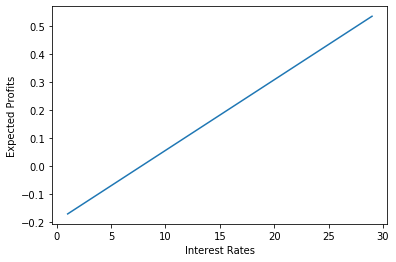

In [46]:
# Testing a range of interest rates on test set, not accurate since interest rates are based on test set results
int_rates = np.arange(1,30, 1)


def changing_int(lamb, int_rates, avg_loan_test):
    #Create an instance of logisticregression named lgstc_reg_l1
    lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

    # Fit logististic regression to training set
    lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

    ep_vals = []
    for i in int_rates:
        ep_vals.append(get_EP(z_optimal_l1, lgstc_reg_l1, 'test', i, avg_int_test))
    y = ep_vals
    x = int_rates

    plt.plot(x, y)
    plt.xlabel("Interest Rates")
    plt.ylabel("Expected Profits")
    plt.show()

changing_int(lambda_optimal, int_rates, avg_loan_test)    